# Below is to prepare and cleanup the collected data from EJFAT and ERSAP for Digital Twin. 

In [2]:
import pandas as pd
import glob
from matplotlib import pyplot as plt
import os

os.chdir("/workspaces/Queue_Simulation_Python/ejfat-data")

In [3]:
# remove outlier data points based on the z-score
def remove_outliers(df, columns, threshold=1):
    from scipy import stats
    import numpy as np

    z = np.abs(stats.zscore(df[columns]))
    outlier_indices = (z > threshold).any(axis=1)
    return df[outlier_indices].index


In [4]:
dfs_event_rate = []
dfs_process_time = []
dfs_drop_total_events = []

for folder in glob.glob("*/"):
    fs = glob.glob(f"{folder}/*.csv")
    folder = folder.replace("dt-vol-", "").replace("/", "")
    for f in fs:
        df = pd.read_csv(f)
        if "currDropTotalEvents" in f:
            df.columns = ["time", "current-drop-total-event-rate"]
            # add a column of folder
                # remove "dt-vol" in folder name
            df["folder"] = folder
            dfs_drop_total_events.append(df)

        elif "Process Time" in f:
            df.columns = ["time", "process-time"]
            # the entry is like "1.22 ms", and remove the "ms" and convert to float
            df["process-time"] = df["process-time"].str.replace("ms", "").astype(float)
            title = "process-time"
            df["folder"] = folder
            dfs_process_time.append(df)

        elif "evRate" in f:
            df.columns = ["time", "event-rate"]
            title = "event-rate"
            df["folder"] = folder
            dfs_event_rate.append(df)

dfs_event_rate = pd.concat(dfs_event_rate, ignore_index=True)
dfs_process_time = pd.concat(dfs_process_time, ignore_index=True)
dfs_drop_total_events = pd.concat(dfs_drop_total_events, ignore_index=True)

# remove outliers
outliers = remove_outliers(dfs_process_time, ["process-time"], 5)
print(f"outliers: {outliers}")
## remove the rows with outliers
dfs_process_time = dfs_process_time.drop(outliers)
dfs_event_rate = dfs_event_rate.drop(outliers)
dfs_drop_total_events = dfs_drop_total_events.drop(outliers)

print(f"type of columns: {dfs_event_rate.dtypes}")

display(dfs_event_rate)
display(dfs_process_time)
display(dfs_drop_total_events)

outliers: Index([294], dtype='int64')
type of columns: time          object
event-rate     int64
folder        object
dtype: object


,time,event-rate,folder
0,2024-06-11 16:02:30,4310,1g-1node
1,2024-06-11 16:02:45,4296,1g-1node
2,2024-06-11 16:03:00,4295,1g-1node
3,2024-06-11 16:03:15,4302,1g-1node
4,2024-06-11 16:03:30,4301,1g-1node
...,...,...,...
618,2024-06-11 17:02:15,8598,2g-1node
619,2024-06-11 17:02:30,8615,2g-1node
620,2024-06-11 17:02:45,8605,2g-1node
621,2024-06-11 17:03:00,8610,2g-1node


,time,process-time,folder
0,2024-06-11 16:02:30,2.00,1g-1node
1,2024-06-11 16:02:45,1.84,1g-1node
2,2024-06-11 16:03:00,1.57,1g-1node
3,2024-06-11 16:03:15,1.82,1g-1node
4,2024-06-11 16:03:30,1.55,1g-1node
...,...,...,...
618,2024-06-11 17:02:15,1.47,2g-1node
619,2024-06-11 17:02:30,1.45,2g-1node
620,2024-06-11 17:02:45,1.51,2g-1node
621,2024-06-11 17:03:00,1.50,2g-1node


,time,current-drop-total-event-rate,folder
0,2024-06-11 16:02:30,0.422,1g-1node
1,2024-06-11 16:02:45,0.444,1g-1node
2,2024-06-11 16:03:00,0.511,1g-1node
3,2024-06-11 16:03:15,0.400,1g-1node
4,2024-06-11 16:03:30,0.378,1g-1node
...,...,...,...
618,2024-06-11 17:02:15,0.489,2g-1node
619,2024-06-11 17:02:30,0.644,2g-1node
620,2024-06-11 17:02:45,0.511,2g-1node
621,2024-06-11 17:03:00,0.556,2g-1node


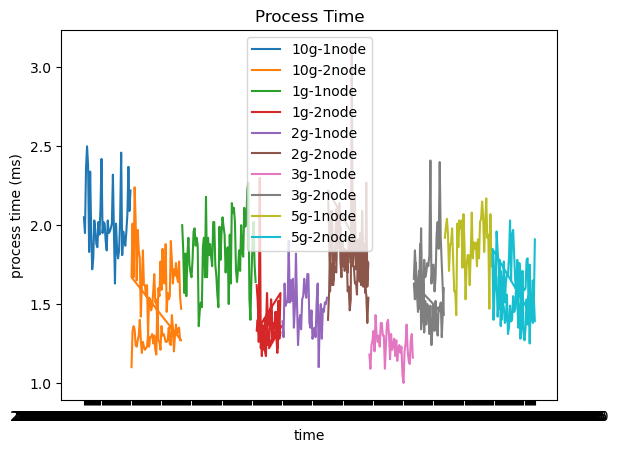

In [5]:
# plot process time
plt.figure()
for folder, df in dfs_process_time.groupby("folder"):
    plt.plot(df["time"], df["process-time"], label=folder)
plt.legend()
plt.title("Process Time")
plt.xlabel("time")
plt.ylabel("process time (ms)")
plt.show()


/tmp/ipykernel_87191/167380829.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_xticklabels(df_mean.index, rotation=30)
/tmp/ipykernel_87191/167380829.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_xticklabels(df_mean.index, rotation=30)
/tmp/ipykernel_87191/167380829.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_xticklabels(df_mean.index, rotation=30)


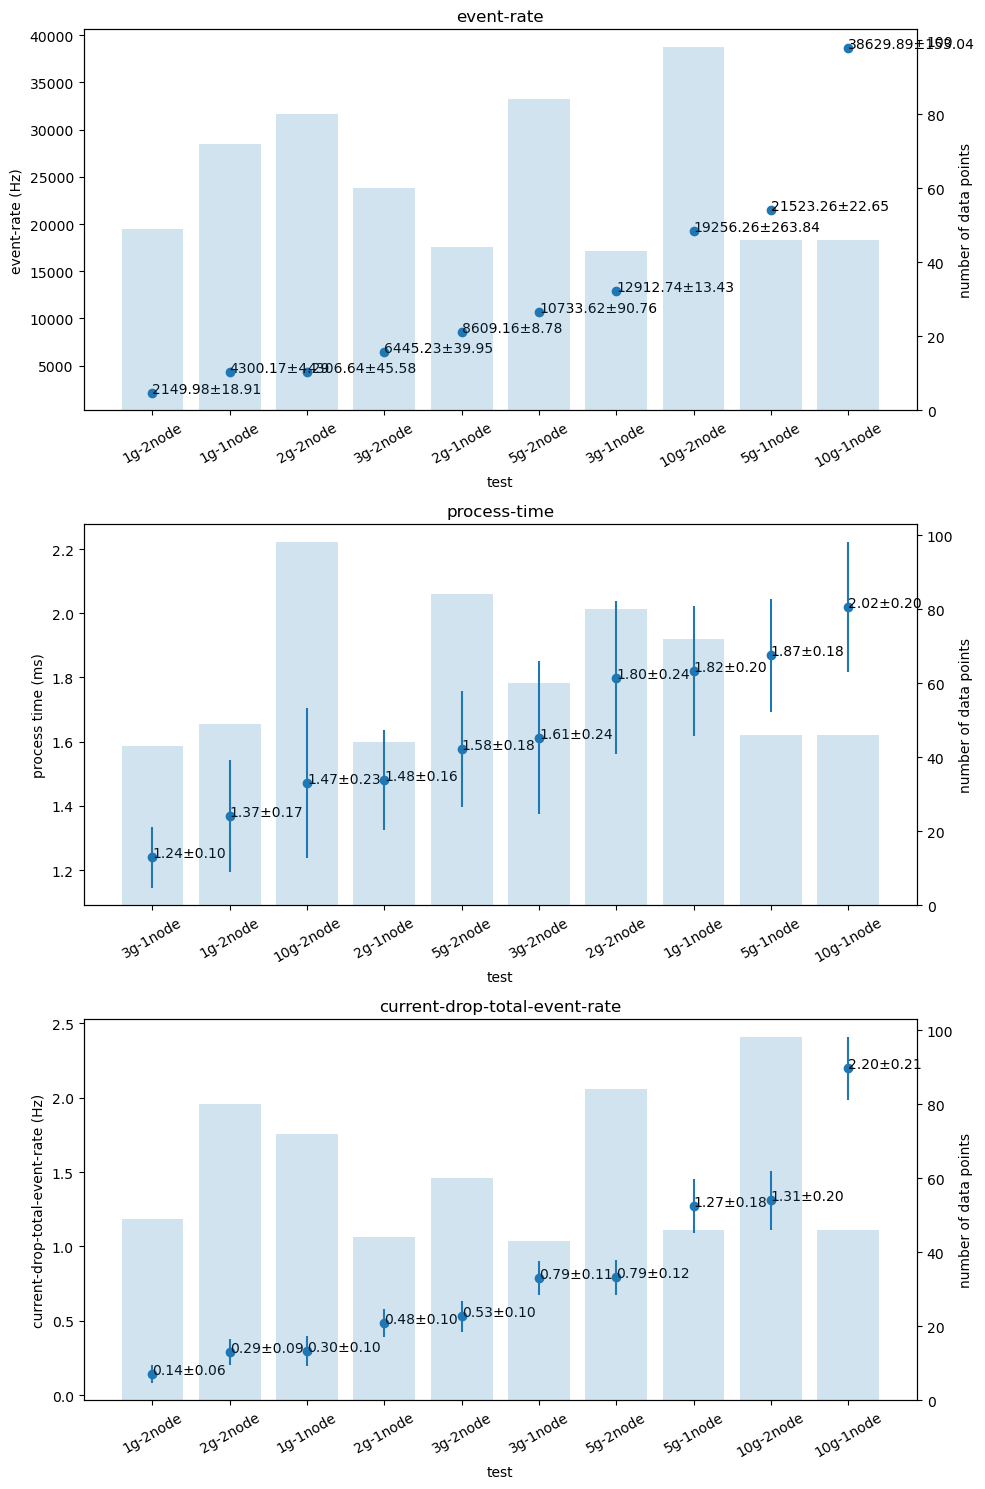

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

dataframes = [dfs_event_rate, dfs_process_time, dfs_drop_total_events]
for idx, df in enumerate(dataframes):
    # get the mean and std of each folder
    df_stat = df.groupby("folder").describe()[df.columns[1]].sort_values("mean")

    df_mean = df_stat["mean"]
    df_std = df_stat["std"]
    df_count = df_stat["count"]

    # plot mean and std of each folder in the same plot. The dot is the mean, and the error bar is the std centered at the mean
    axs[idx].errorbar(df_mean.index, df_mean, yerr=df_std, fmt='o')
    # annotate the mean and percentage of the std
    for i, (mean, std) in enumerate(zip(df_mean, df_std)):
        axs[idx].annotate(f"{mean:.2f}±{std:.2f}", (i, mean))
        
        
    axs[idx].set_xlabel("test")
    # make xlabel vertical
    axs[idx].set_xticklabels(df_mean.index, rotation=30)
    if "process-time" in df.columns[1]:
        axs[idx].set_ylabel("process time (ms)")
    else:
        axs[idx].set_ylabel(df.columns[1]+" (Hz)")
    axs[idx].set_title(df.columns[1])

    # plot the number of data points in each folder as a additional subplot
    ax2 = axs[idx].twinx()
    ax2.set_ylabel("number of data points")
    ax2.bar(df_mean.index, df_count.loc[df_mean.index], alpha=0.2)

plt.tight_layout()

plt.show()

# Below is for calculating Quantity of interest

In [14]:
# define lamba as dfs_event_rate["event-rate"]
ls = dfs_event_rate.groupby("folder").apply(lambda x: x["event-rate"].mean())
## add column name lambda
ls = ls.reset_index()
ls.columns = ["folder", "lambda"]
ls = ls.set_index("folder")
# print(f"ls: {ls}")


# add a column of server number in ls
ls = ls.reset_index()
ls["server-number"] = ls["folder"].apply(lambda x: int(x.split("-")[1][0]))
ls = ls.set_index("folder")
# print(f"ls: {ls}")


# define mu as dfs_process_time["process-time"]
mus = dfs_process_time.groupby("folder").apply(lambda x: 1/(x["process-time"].mean()* 1e-3))
# print(f"mus: {mus}") 

# add mus as a new column in ls by matching the folder name
ls.loc[mus.index, "mu"] = mus.values
# print(f"ls: {ls}")



# calculate the utilization
ls["utilization"] = ls["lambda"] / ls["mu"] / ls["server-number"]
print(f"ls: {ls}")


ls:                  lambda  server-number          mu  utilization
folder                                                         
10g-1node  38629.891304              1  495.156082    78.015585
10g-2node  19256.255102              2  679.423184    14.171032
1g-1node    4300.166667              1  549.324788     7.828095
1g-2node    2149.979592              2  730.362200     1.471858
2g-1node    8609.159091              1  675.053697    12.753295
2g-2node    4306.637500              2  555.902995     3.873551
3g-1node   12912.744186              1  806.149231    16.017809
3g-2node    6445.233333              2  619.962802     5.198081
5g-1node   21523.260870              1  535.070373    40.225103
5g-2node   10733.619048              2  634.010114     8.464864
